## SETUP

In [ ]:
!pip install gym[classic_control]
!pip install dezero

## ch08/gym_play.py

In [2]:
import numpy as np
import gym


env = gym.make('CartPole-v0')
state = env.reset()
done = False

while not done:
    #env.render()
    action = np.random.choice([0, 1])
    next_state, reward, done, info = env.step(action)
    print('action:', action)
#env.close()

action: 0
action: 0
action: 0
action: 1
action: 1
action: 0
action: 0
action: 0
action: 0
action: 0
action: 0
action: 1
action: 0


## ch08/replay_buffer.py

In [3]:
from collections import deque
import random
import numpy as np
import gym


class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        self.buffer.append(data)

    def __len__(self):
        return len(self.buffer)

    def get_batch(self):
        data = random.sample(self.buffer, self.batch_size)

        state = np.stack([x[0] for x in data])
        action = np.array([x[1] for x in data])
        reward = np.array([x[2] for x in data])
        next_state = np.stack([x[3] for x in data])
        done = np.array([x[4] for x in data]).astype(np.int32)
        return state, action, reward, next_state, done


env = gym.make('CartPole-v0')
replay_buffer = ReplayBuffer(buffer_size=10000, batch_size=32)

for episode in range(10):
    state = env.reset()
    done = False

    while not done:
        action = 0
        next_state, reward, done, info = env.step(action)
        replay_buffer.add(state, action, reward, next_state, done)
        state = next_state

state, action, reward, next_state, done = replay_buffer.get_batch()
print(state.shape)  # (32, 4)
print(action.shape)  # (32,)
print(reward.shape)  # (32,)
print(next_state.shape)  # (32, 4)
print(done.shape)  # (32,)

(32, 4)
(32,)
(32,)
(32, 4)
(32,)


## ch08/dqn.py

episode :0, total reward : 14.0
episode :10, total reward : 98.0
episode :20, total reward : 38.0
episode :30, total reward : 20.0
episode :40, total reward : 12.0
episode :50, total reward : 10.0
episode :60, total reward : 23.0
episode :70, total reward : 17.0
episode :80, total reward : 9.0
episode :90, total reward : 124.0
episode :100, total reward : 122.0
episode :110, total reward : 186.0
episode :120, total reward : 156.0
episode :130, total reward : 198.0
episode :140, total reward : 146.0
episode :150, total reward : 200.0
episode :160, total reward : 200.0
episode :170, total reward : 193.0
episode :180, total reward : 200.0
episode :190, total reward : 142.0
episode :200, total reward : 200.0
episode :210, total reward : 200.0
episode :220, total reward : 179.0
episode :230, total reward : 149.0
episode :240, total reward : 200.0
episode :250, total reward : 200.0
episode :260, total reward : 200.0
episode :270, total reward : 200.0
episode :280, total reward : 200.0
episod

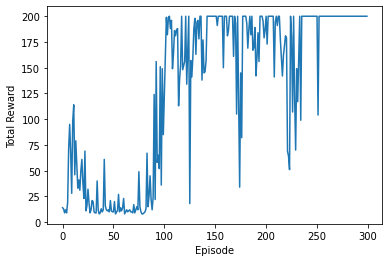

Total Reward: 200.0


In [4]:
import copy
from collections import deque
import random
import matplotlib.pyplot as plt
import numpy as np
import gym
from dezero import Model
from dezero import optimizers
import dezero.functions as F
import dezero.layers as L


class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        self.buffer.append(data)

    def __len__(self):
        return len(self.buffer)

    def get_batch(self):
        data = random.sample(self.buffer, self.batch_size)

        state = np.stack([x[0] for x in data])
        action = np.array([x[1] for x in data])
        reward = np.array([x[2] for x in data])
        next_state = np.stack([x[3] for x in data])
        done = np.array([x[4] for x in data]).astype(np.int32)
        return state, action, reward, next_state, done


class QNet(Model):
    def __init__(self, action_size):
        super().__init__()
        self.l1 = L.Linear(128)
        self.l2 = L.Linear(128)
        self.l3 = L.Linear(action_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x


class DQNAgent:
    def __init__(self):
        self.gamma = 0.98
        self.lr = 0.0005
        self.epsilon = 0.1
        self.buffer_size = 10000
        self.batch_size = 32
        self.action_size = 2

        self.replay_buffer = ReplayBuffer(self.buffer_size, self.batch_size)
        self.qnet = QNet(self.action_size)
        self.qnet_target = QNet(self.action_size)
        self.optimizer = optimizers.Adam(self.lr)
        self.optimizer.setup(self.qnet)

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            state = state[np.newaxis, :]
            qs = self.qnet(state)
            return qs.data.argmax()

    def update(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)
        if len(self.replay_buffer) < self.batch_size:
            return

        state, action, reward, next_state, done = self.replay_buffer.get_batch()
        qs = self.qnet(state)
        q = qs[np.arange(self.batch_size), action]

        next_qs = self.qnet_target(next_state)
        next_q = next_qs.max(axis=1)
        next_q.unchain()
        target = reward + (1 - done) * self.gamma * next_q

        loss = F.mean_squared_error(q, target)

        self.qnet.cleargrads()
        loss.backward()
        self.optimizer.update()

    def sync_qnet(self):
        self.qnet_target = copy.deepcopy(self.qnet)

episodes = 300
sync_interval = 20
env = gym.make('CartPole-v0')
agent = DQNAgent()
reward_history = []

for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)

        agent.update(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

    if episode % sync_interval == 0:
        agent.sync_qnet()

    reward_history.append(total_reward)
    if episode % 10 == 0:
        print("episode :{}, total reward : {}".format(episode, total_reward))


# === Plot ===
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(range(len(reward_history)), reward_history)
plt.show()


# === Play CartPole ===
agent.epsilon = 0  # greedy policy
state = env.reset()
done = False
total_reward = 0

while not done:
    action = agent.get_action(state)
    next_state, reward, done, info = env.step(action)
    state = next_state
    total_reward += reward
    #env.render()
print('Total Reward:', total_reward)